https://towardsdatascience.com/multivariate-time-series-forecasting-653372b3db36

https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

https://towardsdatascience.com/combine-lstm-and-var-for-multivariate-time-series-forecasting-abdcb3c7939b

https://github.com/srpayd/Machine-Learning-and-Time-Series-Analysis--VAR--LSTM-/blob/master/3.%20Data%20Preparation%20%26%20Time%20Series.ipynb

The general steps involved in building a VARMA model are:
- Examine the data
- Visualize the data
- Test for stationarity
- If necessary, transform the data to make it stationary
- Select the appropriate p and q orders
- Instantiate the model and fit it to a training set
- If necessary, invert the earlier transformation
- Evaluate model predictions against a known test set
- Forecast the future

In [223]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import ast
from collections import defaultdict
from datetime import datetime, timedelta
import pickle

# from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [113]:
## import the price data
prices_df = pd.read_csv(
    '../Data/ds_spx_1990-2020_survivorship_free_prices.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

## import S&P index price
spx_df = pd.read_csv(
    '../Data/ds_spx_1973-2020_index.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

## import the mapping table 
map_df = pd.read_csv(
    '../Data/eikon_map_table.csv', 
    index_col = 0
    )

## import the index constituents data
constituents_df = pd.read_csv(
    '../Data/eikon_spx_constituents_1995.csv', 
    index_col = 0, 
    parse_dates = True
    )
constituents_df['Index Constituents'] = constituents_df['Index Constituents'].apply(ast.literal_eval)

## import the IBES analysts estimates data
estimates_df = pd.read_csv(
        '../Data/eikon_ibes_data_1995.csv',
        index_col = 0,
        parse_dates = True, 
)#.fillna(method = 'ffill').dropna(axis = 1, how = 'any')

In [114]:
# create a monthly date range 
dates = pd.date_range('1995-01', '2020-01', freq = 'BM').strftime('%Y-%m')

# # resample price data to weekly intervals starting in 2005
prices_df = prices_df.loc['1995-01-01':, :]
spx_df = spx_df.loc['1995-01-01':, :]
# # prices_df = prices_df.resample('W').last()
# # spx_df = spx_df.resample('W').last()

# # create returns dataframes
# returns_df = prices_df.pct_change()
# returns_df.iloc[0, :] = 0
# spx_returns_df = spx_df.pct_change().fillna(0)

# # convert values to NaNs for any time periods where a company is not  a
# # constituent of the S&P 500 
# for month in dates: 
#     constituents = constituents_df.loc[month, 'Index Constituents'].values[0]
#     constituents = map_df.loc[constituents, 'ISIN'].values
#     not_in_index = [company for company in prices_df[month].columns if company not in constituents]
#     prices_df.loc[month, not_in_index] = np.nan
#     returns_df.loc[month, not_in_index] = np.nan
    
# # for use in the autoencoder, remove any companies that have NaN values
# returns_df.dropna(axis = 1, how = 'any', inplace = True)

In [115]:
estimates_df.columns = [
    'RIC',
    'Number of Analysts', 
    'Earnings Per Share FY0 - Actual',
    'Earnings Per Share FY0 - Mean', 
    'Earnings Per Share FY1 - Mean',
    'Earnings Per Share FY2 - Mean', 
    'Earnings Per Share FQ0 - Actual',
    'Earnings Per Share FQ0 - Mean', 
    'Earnings Per Share FQ1 - Mean',
    'Earnings Per Share FQ2 - Mean', 
    'Earnings Per Share FQ3 - Mean',
    'Earnings Per Share FQ4 - Mean'
]

estimates_df.head()

,RIC,Number of Analysts,Earnings Per Share FY0 - Actual,Earnings Per Share FY0 - Mean,Earnings Per Share FY1 - Mean,Earnings Per Share FY2 - Mean,Earnings Per Share FQ0 - Actual,Earnings Per Share FQ0 - Mean,Earnings Per Share FQ1 - Mean,Earnings Per Share FQ2 - Mean,Earnings Per Share FQ3 - Mean,Earnings Per Share FQ4 - Mean
1990-01-31,SK.N^E98,24.0,0.84667,0.83588,0.92667,1.10083,0.20000,0.23308,0.30143,0.22500,0.23750,0.24333
1990-01-31,CSCO.OQ,0.0,0.00118,NaN,NaN,NaN,0.00069,NaN,NaN,NaN,NaN,NaN
1990-01-31,EXPD.OQ,9.0,0.03906,0.03917,0.04861,0.05893,0.00417,0.00375,0.00531,0.00625,0.00625,0.00563
1990-01-31,CERN.OQ,3.0,0.00781,NaN,0.01667,0.01896,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31,TAPb.N^D04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
## split the data into training and test data
train_start_date = '1995-01-01'
train_end_date = '2014-12-31'
test_start_date = '2015-01-01'
test_end_date = '2019-12-31'

train_prices_df = prices_df[train_start_date:train_end_date]
test_prices_df = prices_df[test_start_date:test_end_date]

# train_returns_df = returns_df[train_start_date:train_end_date]
# test_returns_df = returns_df[test_start_date:test_end_date]

train_spx_df = spx_df[train_start_date:train_end_date]
test_spx_df = spx_df[test_start_date: test_end_date]

# train_spx_returns_df = spx_returns_df[train_start_date: train_end_date]
# test_spx_returns_df = spx_returns_df[test_start_date: test_end_date]

train_estimates_df = estimates_df[train_start_date:train_end_date]
test_estimates_df = estimates_df[test_start_date:test_end_date]

In [117]:
map_df.loc[map_df['ISIN'] == 'US8425871071', :] # Most representative according to AE

,RIC,SEDOL,ISIN,CUSIP,Company Common Name,GICS Sector Name,GICS Industry Name
Instrument,,,,,,,
SO.N,SO.N,2829601,US8425871071,842587107,Southern Co,Utilities,Electric Utilities


In [162]:
start_date = '1995-01-01'
end_date = '2019-12-31'

In [163]:
price_df = prices_df.loc[start_date:end_date, 'US8425871071']
price_df = price_df.resample('M').last()
price_df

Code
1995-01-31    12.737100
1995-02-28    12.584600
1995-03-31    12.432000
1995-04-30    12.584600
1995-05-31    13.499800
                ...    
2019-08-31    58.259998
2019-09-30    61.770000
2019-10-31    62.660000
2019-11-30    61.990002
2019-12-31    63.700001
Freq: M, Name: US8425871071, Length: 300, dtype: float32

In [169]:
top_co_df = copy.deepcopy(estimates_df.loc[estimates_df['RIC'] == 'SO.N', :])
top_co_df.drop('RIC', axis = 1, inplace = True)
top_co_df = top_co_df.loc[start_date:end_date]

In [170]:
price_df.shape, top_co_df.shape

((300,), (300, 11))

In [171]:
top_co_df['price'] = price_df.values
top_co_df['eps_fq0_surprise'] = top_co_df['Earnings Per Share FQ0 - Actual'] - top_co_df['Earnings Per Share FQ0 - Mean']
top_co_df['eps_fy0_surprise'] = top_co_df['Earnings Per Share FY0 - Actual'] - top_co_df['Earnings Per Share FY0 - Mean']

In [172]:
top_co_df.head()

,Number of Analysts,Earnings Per Share FY0 - Actual,Earnings Per Share FY0 - Mean,Earnings Per Share FY1 - Mean,Earnings Per Share FY2 - Mean,Earnings Per Share FQ0 - Actual,Earnings Per Share FQ0 - Mean,Earnings Per Share FQ1 - Mean,Earnings Per Share FQ2 - Mean,Earnings Per Share FQ3 - Mean,Earnings Per Share FQ4 - Mean,price,eps_fq0_surprise,eps_fy0_surprise
1995-01-31,28.0,1.61,1.59389,1.66107,1.73125,0.27,0.24714,0.28333,0.40500,0.72000,0.275,12.7371,0.02286,0.01611
1995-02-28,27.0,1.61,1.59389,1.66444,1.72778,0.27,0.24714,0.28750,0.40500,0.72000,0.275,12.5846,0.02286,0.01611
1995-03-31,28.0,1.61,1.59389,1.66286,1.72200,0.27,0.24714,0.30125,0.40250,0.71250,0.255,12.4320,0.02286,0.01611
1995-04-28,28.0,1.61,1.59389,1.66071,1.72278,0.31,0.30556,0.39750,0.69750,0.24250,0.300,12.5846,0.00444,0.01611
1995-05-31,29.0,1.61,1.59389,1.66448,1.72500,0.31,0.30556,0.38833,0.70667,0.24333,0.300,13.4998,0.00444,0.01611


In [173]:
top_co_df = top_co_df.fillna(method = 'ffill') 
top_co_df.isna().sum()

Number of Analysts                 0
Earnings Per Share FY0 - Actual    0
Earnings Per Share FY0 - Mean      0
Earnings Per Share FY1 - Mean      0
Earnings Per Share FY2 - Mean      0
Earnings Per Share FQ0 - Actual    0
Earnings Per Share FQ0 - Mean      0
Earnings Per Share FQ1 - Mean      0
Earnings Per Share FQ2 - Mean      0
Earnings Per Share FQ3 - Mean      0
Earnings Per Share FQ4 - Mean      0
price                              0
eps_fq0_surprise                   0
eps_fy0_surprise                   0
dtype: int64

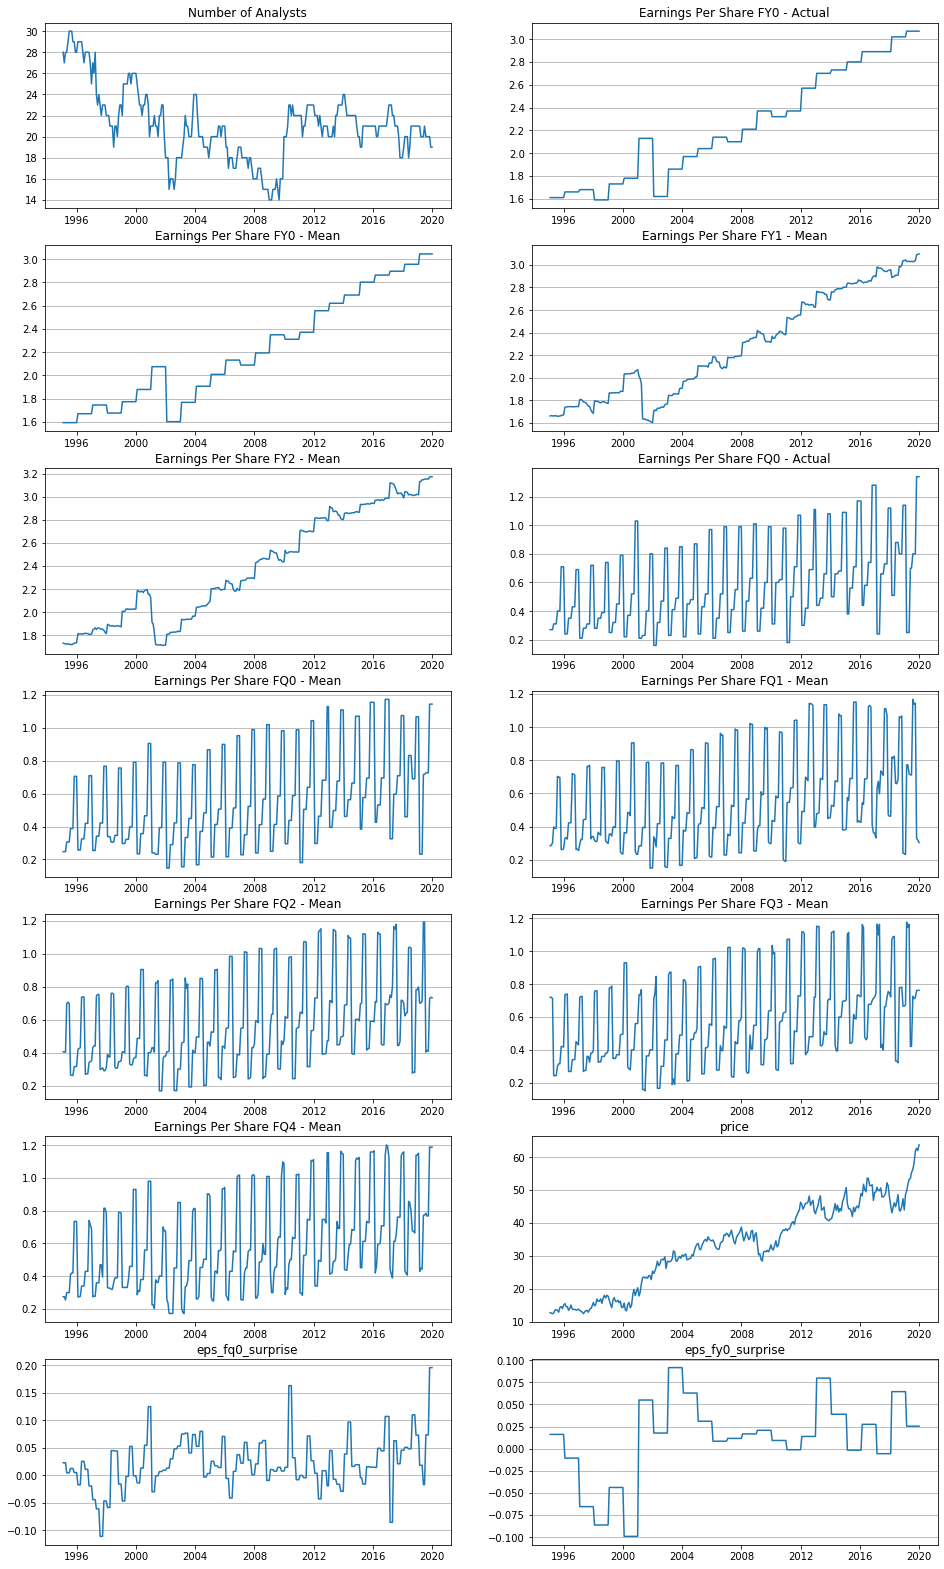

In [175]:
n_feat = top_co_df.shape[1]
if n_feat % 2 == 0:
    x = 0
else: 
    x =1
    
fig, axs = plt.subplots(nrows = (n_feat // 2) + x, ncols = 2, figsize=(16, n_feat * 2))

for i in range(n_feat): 
    col = top_co_df.columns[i]
    axs[i//2, i%2].plot(top_co_df[col], label = col)
    axs[i//2, i%2].grid(axis = 'y')
    axs[i//2, i%2].set_title(col)
plt.show()

---
## Check for stationarity

In [176]:
def adf_test(series, title = ''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag = 'AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [177]:
for col in top_co_df.columns:
    adf_test(top_co_df[col], title = col)
    print()

Augmented Dickey-Fuller Test: Number of Analysts
ADF test statistic       -2.895299
p-value                   0.045897
# lags used               0.000000
# observations          299.000000
critical value (1%)      -3.452411
critical value (5%)      -2.871255
critical value (10%)     -2.571947
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: Earnings Per Share FY0 - Actual
ADF test statistic        0.148914
p-value                   0.969246
# lags used              12.000000
# observations          287.000000
critical value (1%)      -3.453342
critical value (5%)      -2.871664
critical value (10%)     -2.572164
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Augmented Dickey-Fuller Test: Earnings Per Share FY0 - Mean
ADF test statistic       -0.307029
p-value                   0.924503
# lags used               0.000000
#

### Transform by first differencing

In [178]:
top_co_diff_df = top_co_df.diff().iloc[1:, :].fillna(0)

for col in top_co_df.columns:
    adf_test(top_co_diff_df[col], title = col)
    print()

Augmented Dickey-Fuller Test: Number of Analysts
ADF test statistic     -1.810624e+01
p-value                 2.545127e-30
# lags used             0.000000e+00
# observations          2.980000e+02
critical value (1%)    -3.452486e+00
critical value (5%)    -2.871288e+00
critical value (10%)   -2.571964e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: Earnings Per Share FY0 - Actual
ADF test statistic     -7.182233e+00
p-value                 2.631621e-10
# lags used             1.100000e+01
# observations          2.870000e+02
critical value (1%)    -3.453342e+00
critical value (5%)    -2.871664e+00
critical value (10%)   -2.572164e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: Earnings Per Share FY0 - Mean
ADF test statistic     -1.746076e+01
p-value                 4.598609e-30
# lags used  

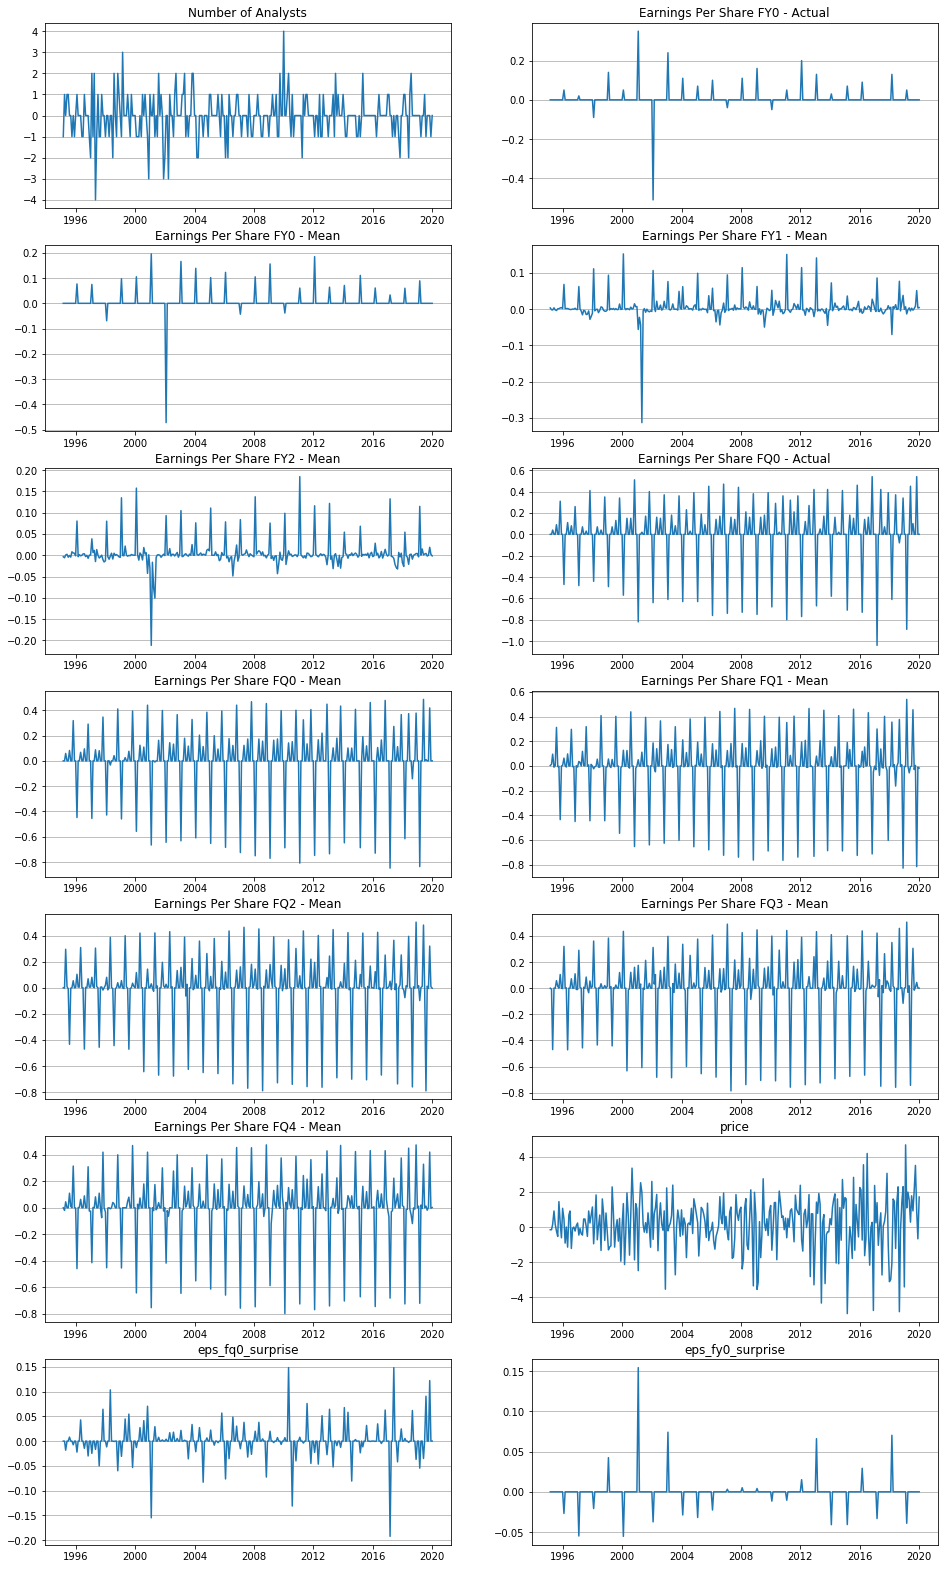

In [179]:
n_feat = top_co_df.shape[1]
if n_feat % 2 == 0:
    x = 0
else: 
    x =1
    
fig, axs = plt.subplots(nrows = (n_feat // 2) + x, ncols = 2, figsize=(16, n_feat * 2))

for i in range(n_feat): 
    col = top_co_df.columns[i]
    axs[i//2, i%2].plot(top_co_diff_df[col], label = col)
    axs[i//2, i%2].grid(axis = 'y')
    axs[i//2, i%2].set_title(col)
plt.show()

In [180]:
top_co_diff_df.isna().sum()

Number of Analysts                 0
Earnings Per Share FY0 - Actual    0
Earnings Per Share FY0 - Mean      0
Earnings Per Share FY1 - Mean      0
Earnings Per Share FY2 - Mean      0
Earnings Per Share FQ0 - Actual    0
Earnings Per Share FQ0 - Mean      0
Earnings Per Share FQ1 - Mean      0
Earnings Per Share FQ2 - Mean      0
Earnings Per Share FQ3 - Mean      0
Earnings Per Share FQ4 - Mean      0
price                              0
eps_fq0_surprise                   0
eps_fy0_surprise                   0
dtype: int64

___
## Train Test Split

In [187]:
top_co_diff_df.shape, top_co_df.shape

((299, 14), (300, 14))

In [202]:
# 3 years of test data
train_len = top_co_diff_df.shape[0] - 60
# train_len = top_co_df.shape[0] - 36

train = top_co_diff_df.iloc[:train_len]
test = top_co_diff_df.iloc[train_len:]
# train = top_co_df.iloc[:train_len]
# test = top_co_df.iloc[train_len:]

train.shape, test.shape

((239, 14), (60, 14))

In [189]:
train.isna().sum()

Number of Analysts                 0
Earnings Per Share FY0 - Actual    0
Earnings Per Share FY0 - Mean      0
Earnings Per Share FY1 - Mean      0
Earnings Per Share FY2 - Mean      0
Earnings Per Share FQ0 - Actual    0
Earnings Per Share FQ0 - Mean      0
Earnings Per Share FQ1 - Mean      0
Earnings Per Share FQ2 - Mean      0
Earnings Per Share FQ3 - Mean      0
Earnings Per Share FQ4 - Mean      0
price                              0
eps_fq0_surprise                   0
eps_fy0_surprise                   0
dtype: int64

___
## Scale Data

In [190]:
scaler = MinMaxScaler()

scaler.fit(train) # WE ONLY FIT TO TRAINING DATA
scaled_train = scaler.transform(train) # each column ranges from 0 to 1
scaled_test = scaler.transform(test)

scaled_train.max(), scaled_test.max()

(1.0, 1.172276473899739)

---
## Build the VARMAX model

In [191]:
train.tail()

,Number of Analysts,Earnings Per Share FY0 - Actual,Earnings Per Share FY0 - Mean,Earnings Per Share FY1 - Mean,Earnings Per Share FY2 - Mean,Earnings Per Share FQ0 - Actual,Earnings Per Share FQ0 - Mean,Earnings Per Share FQ1 - Mean,Earnings Per Share FQ2 - Mean,Earnings Per Share FQ3 - Mean,Earnings Per Share FQ4 - Mean,price,eps_fq0_surprise,eps_fy0_surprise
2014-08-29,0.0,0.0,0.0,0.00143,-0.00091,0.00,0.00000,-0.01000,-0.0040,0.00015,-0.00392,1.110001,0.00000,0.0
2014-09-30,0.0,0.0,0.0,0.00048,0.00273,0.00,0.00000,0.00000,0.0000,0.00000,0.00000,-0.750000,0.00000,0.0
2014-10-31,0.0,0.0,0.0,0.00547,0.00522,0.41,0.40684,-0.68836,0.2105,0.09560,0.42475,2.709999,0.00316,0.0
2014-11-28,-1.0,0.0,0.0,0.00894,0.00244,0.00,0.00000,-0.00154,0.0014,0.00380,0.01550,1.070000,0.00000,0.0
2014-12-31,-1.0,0.0,0.0,-0.00139,-0.00442,0.00,0.00000,0.00075,-0.0020,-0.00200,-0.00800,1.680000,0.00000,0.0


In [192]:
# Issues with some of the features

cols = [
    0, 
#     1, 
    2, 
    3,
    4, 
#     5, 
    6, 
    7, 
    8, 
    9, 
    10, 
    11, 
    12, 
    13
]

model = VARMAX(train.iloc[:, cols], order=(3,0), trend = 'c')
results = model.fit(maxiter = 100, disp = False)
results.summary()

/Users/finlayoneill/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  % freq, ValueWarning)
/Users/finlayoneill/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Dep. Variable:,"['Number of Analysts', 'Earnings Per Share FY0 - Mean', 'Earnings Per Share FY1 - Mean', 'Earnings Per Share FY2 - Mean', 'Earnings Per Share FQ0 - Mean', 'Earnings Per Share FQ1 - Mean', 'Earnings Per Share FQ2 - Mean', 'Earnings Per Share FQ3 - Mean', 'Earnings Per Share FQ4 - Mean', 'price', 'eps_fq0_surprise', 'eps_fy0_surprise']",No. Observations:,239
Model:,VAR(3),Log Likelihood,4829.640
,+ intercept,AIC,-8615.279
Date:,"Thu, 20 Aug 2020",BIC,-6800.565
Time:,11:29:24,HQIC,-7884.000
Sample:,02-28-1995,,
,- 12-31-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"47.99, 37.50, 40.53, 34.94, 68.94, 90.24, 64.33, 73.73, 31.74, 43.62, 56.97, 23.96",Jarque-Bera (JB):,"27.03, 48369.18, 1360.07, 3315.07, 4942.20, 11049.07, 155.62, 32.00, 452.39, 22.23, 145.01, 4730.07"
Prob(Q):,"0.18, 0.58, 0.45, 0.70, 0.00, 0.00, 0.01, 0.00, 0.82, 0.32, 0.04, 0.98",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.71, 1.98, 1.53, 0.48, 6.44, 7.98, 1.30, 0.98, 1.61, 2.37, 0.94, 0.47",Skew:,"0.35, -5.81, 1.35, -1.76, -0.55, -1.27, -0.76, -0.24, 0.15, -0.56, 0.35, 1.02"


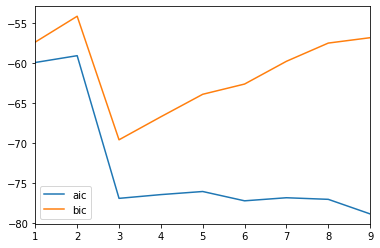

In [154]:
aic_bic_df = pd.DataFrame()
for i in range(1, 10):
    
    model = VAR(train.iloc[:, cols].values)
    results = model.fit(i)
    
    aic_bic_df.loc[i, 'aic'] = results.aic
    aic_bic_df.loc[i, 'bic'] = results.bic
    
#     print('Order =', i)
#     print('AIC: ', results.aic)
#     print('BIC: ', results.bic)
#     print()

aic_bic_df.plot()

In [193]:
predictions_df = results.forecast(60)
predictions_df

,Number of Analysts,Earnings Per Share FY0 - Mean,Earnings Per Share FY1 - Mean,Earnings Per Share FY2 - Mean,Earnings Per Share FQ0 - Mean,Earnings Per Share FQ1 - Mean,Earnings Per Share FQ2 - Mean,Earnings Per Share FQ3 - Mean,Earnings Per Share FQ4 - Mean,price,eps_fq0_surprise,eps_fy0_surprise
2015-01-30,-0.288522,0.043309,0.085263,0.078738,-0.667723,0.209209,0.078388,0.376456,-0.663916,-0.679428,-0.012813,-0.004275
2015-02-27,-0.186777,0.007247,-0.003469,-0.006626,0.025239,0.006797,-0.006101,-0.020303,0.015785,-0.549801,-0.007645,0.002105
2015-03-31,-0.441904,-0.002763,-0.005067,-0.003146,-0.009639,0.010880,-0.006739,-0.000735,-0.007984,0.386415,0.000674,-0.000013
2015-04-30,0.083337,-0.007801,-0.028505,-0.021192,0.199684,0.074578,0.401382,-0.664029,0.190699,0.881050,0.020693,0.000927
2015-05-29,-0.150853,0.004316,0.001371,0.005146,0.001582,-0.013859,-0.020369,0.029478,0.015524,-0.261091,-0.001189,0.000336
2015-06-30,0.109439,-0.001829,-0.000005,0.001742,0.022126,-0.000627,-0.005191,-0.014426,0.026275,-0.068882,0.001337,-0.001209
2015-07-31,-0.208416,-0.003484,-0.003916,-0.006305,0.067604,0.393277,-0.671666,0.225229,0.076518,0.062200,-0.011532,0.000380
2015-08-31,0.276914,0.005939,0.005078,0.003731,-0.014289,-0.018054,0.030425,0.002014,-0.022083,0.522834,0.001682,-0.000229
2015-09-30,0.117335,0.002095,0.002922,0.003992,0.011149,-0.007655,-0.015863,0.014011,0.007678,0.103797,0.000096,-0.000304
2015-10-30,0.098640,-0.007531,-0.007174,-0.012834,0.373051,-0.636185,0.220638,0.055616,0.367567,0.364838,-0.002595,0.000238


In [203]:
last_price = top_co_df['price'][-61]
last_price

49.11

In [210]:
top_co_df.loc['2014-12-31', 'price']

49.11000061035156

In [221]:
pred = top_co_df.loc['2014-12-31', 'price'] + predictions_df['price'].cumsum()
act = top_co_df.loc['2015-01-30':, 'price']

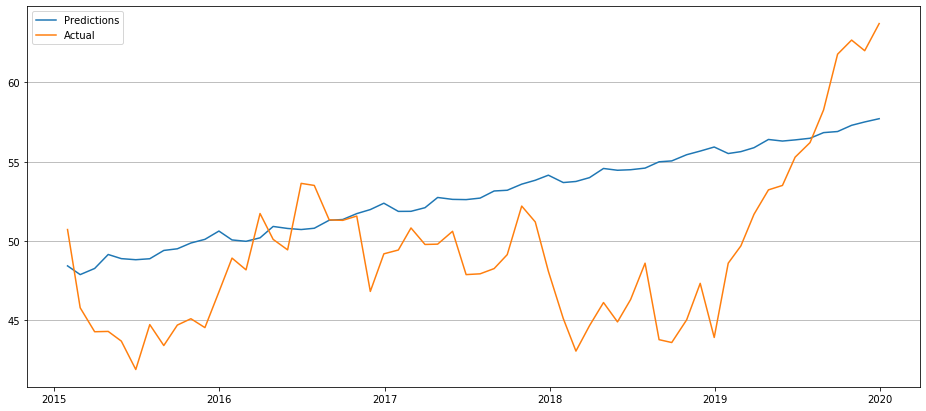

In [222]:
plt.figure(figsize = (16, 7))
plt.plot(pred, label = 'Predictions')
plt.plot(act, label = 'Actual')
plt.legend()
plt.grid(axis = 'y');

In [225]:
print('The R2 score is:\t{:0.3f}'.format(r2_score(act, pred)))

The R2 score is:	-0.226


Worst case scenario:

I have a chart I can use to compare with the LSTM model. The problem is that the "forecast" is for a 60 month period instead of a rolling window 1 month at a time. 

___
## Time Series Generator

In [41]:
n_input = 12
n_cols = scaled_train.shape[1]

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)